In [1]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# CSVファイルを読み込む
train_test_data = pd.read_csv('input/status.csv')
station_data = pd.read_csv('input/station.csv')
trip_data = pd.read_csv('input/trip.csv')
print("train_test_data;",len(train_test_data))
print("station_data;",len(station_data))
print("trip_data;",len(trip_data))
train_test_data.describe()

train_test_data; 1226400
station_data; 70
trip_data; 669959


,id,year,month,day,hour,station_id,bikes_available,predict
count,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,809995.000000,1.226400e+06
mean,6.131995e+05,2.014166e+03,6.526027e+00,1.572055e+01,1.150000e+01,3.450000e+01,8.477600,1.575342e-01
std,3.540313e+05,6.874054e-01,3.447853e+00,8.796251e+00,6.922189e+00,2.020521e+01,3.894038,3.643039e-01
min,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,3.065998e+05,2.014000e+03,4.000000e+00,8.000000e+00,5.750000e+00,1.700000e+01,6.000000,0.000000e+00
50%,6.131995e+05,2.014000e+03,7.000000e+00,1.600000e+01,1.150000e+01,3.450000e+01,8.000000,0.000000e+00
75%,9.197992e+05,2.015000e+03,1.000000e+01,2.300000e+01,1.725000e+01,5.200000e+01,11.000000,0.000000e+00
max,1.226399e+06,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.900000e+01,27.000000,1.000000e+00


In [3]:
# 2つのカラムでグループ化
grouped_data = train_test_data.groupby(['year', 'month'])

# 2013/9~2015/8までの24か月分のデータを月ごとにグループ化
train_test_per_month = []
# グループごとにデータを表示
for group, group_data in grouped_data:
    print("Group:", group)
    print(group_data)
    train_test_per_month.append(group_data)

print([len(v) for v in train_test_per_month])


Group: (2013, 9)
              id  year  month  day  hour  station_id  bikes_available  predict
0              0  2013      9    1     0           0             11.0        0
1              1  2013      9    1     1           0             11.0        0
2              2  2013      9    1     2           0             11.0        0
3              3  2013      9    1     3           0             11.0        0
4              4  2013      9    1     4           0             11.0        0
...          ...   ...    ...  ...   ...         ...              ...      ...
1209595  1209595  2013      9   30    19          69              NaN        0
1209596  1209596  2013      9   30    20          69              NaN        0
1209597  1209597  2013      9   30    21          69              NaN        0
1209598  1209598  2013      9   30    22          69              NaN        0
1209599  1209599  2013      9   30    23          69              NaN        0

[50400 rows x 8 columns]
Group: (2

In [4]:
train_base_data = pd.DataFrame()
train_list = []
test_list = []
for i, train_test_data in enumerate(train_test_per_month):
    # 2013/9~2014/8までのデータ。予測データなし
    # print("i:{}".format(i))
    if i < 12:
        train_base_data = pd.concat([train_test_data])
    else:
        test_data = train_test_data[train_test_data["predict"] == 1]
        test_list.append(test_data)
        print("test_data")
        print(len(test_data))
        print(test_data)
            
        train_data = train_test_data[train_test_data["predict"] == 0]
        train_data = train_data.dropna(how='any')
        if i ==12:
            train_data = pd.concat([train_base_data,train_data])
            # print("len(train_base_data){}".format(len(train_base_data)))
        else:
            train_data = pd.concat([train_data_before,train_data])

        train_list.append(train_data)
        train_data_before = train_data
        # print("train_data")
        # print(train_data)

test_data
16100
              id  year  month  day  hour  station_id  bikes_available  predict
8761        8761  2014      9    1     1           0              NaN        1
8762        8762  2014      9    1     2           0              NaN        1
8763        8763  2014      9    1     3           0              NaN        1
8764        8764  2014      9    1     4           0              NaN        1
8765        8765  2014      9    1     5           0              NaN        1
...          ...   ...    ...  ...   ...         ...              ...      ...
1218331  1218331  2014      9   29    19          69              NaN        1
1218332  1218332  2014      9   29    20          69              NaN        1
1218333  1218333  2014      9   29    21          69              NaN        1
1218334  1218334  2014      9   29    22          69              NaN        1
1218335  1218335  2014      9   29    23          69              NaN        1

[16100 rows x 8 columns]
test_data


In [5]:
# データ整理
# train_list ：2012/9~2014/8+2014/9のpredict=0の学習データが配列0番目のpd.DataFrame、2015/8までの11番目配列まである。
# test_list ：2014/9のpredict=1の学習データが配列0番目のpd.DataFrame、2015/8までの11番目配列まである。


In [6]:
marge_data_list = []
merge_test_data_list = []
for train in train_list:
    #trainとcustomerを結合
    left_DataFrame = train
    right_DataFrame = station_data
    merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="station_id", right_on="station_id",suffixes=('_x', '_y'))
  
    #日付編集
    merge_data['installation_date'] = pd.to_datetime(merge_data['installation_date'])
    merge_data['installation_year'] = pd.to_datetime(merge_data['installation_date']).dt.year
    merge_data['installation_month'] = pd.to_datetime(merge_data['installation_date']).dt.month
    merge_data['installation_day'] = pd.to_datetime(merge_data['installation_date']).dt.day
    merge_data['Day_of_Week'] = merge_data['installation_date'].dt.day_name()
    #曜日エンコード
    day_mapping = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1, 'Sunday': 1}
    merge_data['Week_Weekend'] = merge_data['Day_of_Week'].map(day_mapping)
    merge_data = merge_data.drop(['installation_date','Day_of_Week'], axis=1) #'Day_of_Week' 列を削除

    # Cityのカテゴリかる変数をワンホットエンコーディング
    merge_data['city'] = merge_data['city'].astype('str')
    merge_data = pd.get_dummies(merge_data, columns=['city'],dtype=int)

    marge_data_list.append(merge_data)
    columns_list = merge_data.columns.tolist()

for test in test_list:
    #trainとcustomerを結合
    left_DataFrame = test
    right_DataFrame = station_data
    merge_test_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="station_id", right_on="station_id",suffixes=('_x', '_y'))

    #日付編集
    merge_test_data['installation_date'] = pd.to_datetime(merge_test_data['installation_date'])
    merge_test_data['installation_year'] = pd.to_datetime(merge_test_data['installation_date']).dt.year
    merge_test_data['installation_month'] = pd.to_datetime(merge_test_data['installation_date']).dt.month
    merge_test_data['installation_day'] = pd.to_datetime(merge_test_data['installation_date']).dt.day
    merge_test_data['Day_of_Week'] = merge_test_data['installation_date'].dt.day_name()
    #曜日エンコード
    day_mapping = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1, 'Sunday': 1}
    merge_test_data['Week_Weekend'] = merge_test_data['Day_of_Week'].map(day_mapping)
    merge_test_data = merge_test_data.drop(['installation_date','Day_of_Week'], axis=1) #'Day_of_Week' 列を削除

    # Cityのカテゴリかる変数をワンホットエンコーディング
    merge_test_data['city'] = merge_test_data['city'].astype('str')
    merge_test_data = pd.get_dummies(merge_test_data, columns=['city'],dtype=int)

    merge_test_data_list.append(merge_test_data)

    columns_list = merge_test_data.columns.tolist()
print(columns_list)

['id', 'year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']


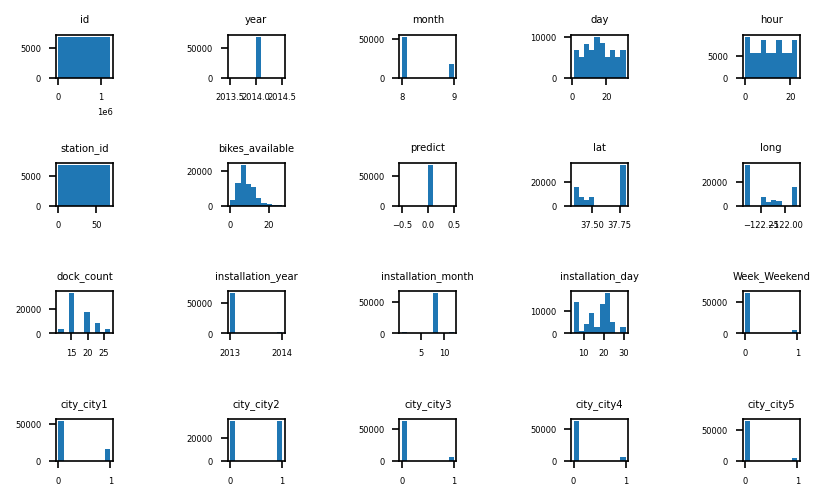

In [7]:
import matplotlib.pyplot as plt
marge_data_list[0].head()

fig = plt.figure(dpi=150)
for i, col in enumerate(marge_data_list[0].columns):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    # plt.figure(figsize=(4, 4))
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(marge_data_list[0][col])
    plt.title(col)



In [8]:
train_total = []
test_total = []
test_id_list = []

# デバッグ用にスライス定数を定義.大きめに設定しておけばすべてのデータで推論してくれる。
DEBUG_SLICE = 20

for train in marge_data_list[:DEBUG_SLICE]:
    train = train.drop(['id'], axis=1) 
    train_total.append(train)
    columns_list = train.columns.tolist()
print(columns_list)

for test in merge_test_data_list[:DEBUG_SLICE]:
    #trainとcustomerを結合
    test_id = test["id"]
    test = test.drop(['id'], axis=1) 
    test_total.append(test)
    test_id_list.append(test_id)

    columns_list = test.columns.tolist()
print(columns_list)


['year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']
['year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']


In [9]:
train_total[0].info()
# print(merge_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   bikes_available     69580 non-null  float64
 6   predict             69580 non-null  int64  
 7   lat                 69580 non-null  float64
 8   long                69580 non-null  float64
 9   dock_count          69580 non-null  int64  
 10  installation_year   69580 non-null  int32  
 11  installation_month  69580 non-null  int32  
 12  installation_day    69580 non-null  int32  
 13  Week_Weekend        69580 non-null  int64  
 14  city_city1          69580 non-null  int64  
 15  city_city2          69580 non-null  int64  
 16  city

In [10]:
train_total[0].describe()

,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
count,69580.0,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.0,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000
mean,2014.0,8.251509,15.301811,11.384306,34.500000,8.346881,0.0,37.590244,-122.218416,17.657143,2013.042857,7.928571,16.985714,0.071429,0.228571,0.500000,0.100000,0.100000,0.071429
std,0.0,0.433884,8.332649,6.982292,20.205343,3.975875,0.0,0.202015,0.207947,3.981721,0.202536,1.457223,6.994932,0.257541,0.419916,0.500004,0.300002,0.300002,0.257541
min,2014.0,8.000000,1.000000,0.000000,0.000000,0.000000,0.0,37.329730,-122.418950,11.000000,2013.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,8.000000,9.000000,5.000000,17.000000,6.000000,0.0,37.389220,-122.400810,15.000000,2013.000000,8.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,8.000000,15.000000,11.000000,34.500000,8.000000,0.0,37.631165,-122.312120,15.000000,2013.000000,8.000000,19.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,2014.0,9.000000,22.000000,17.000000,52.000000,11.000000,0.0,37.788450,-122.076710,19.000000,2013.000000,8.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2014.0,9.000000,31.000000,23.000000,69.000000,27.000000,0.0,37.804770,-121.877350,27.000000,2014.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train_total[0].head()


,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
0,2014,8,1,0,0,12.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
1,2014,8,1,1,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
2,2014,8,1,2,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
3,2014,8,1,3,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
4,2014,8,1,4,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0


In [12]:
# スコア低下したので除外
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = train_total[train_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = train_total[train_total.per_terminal > 0].per_terminal.min()
# per_customer_min = train_total[train_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# train_total["TX_AMOUNT"] += tx_amount_min
# train_total["per_terminal"] += per_terminal_min
# train_total["per_customer"] += per_customer_min
# train_total.describe()

In [13]:
# # 対数変換
# log_list = ["x_customer_id","y_customer_id","mean_amount","std_amount","mean_nb_tx_per_day","x_terminal_id","y_terminal_id"]
# fig = plt.figure(dpi=150)
# for i,indent in enumerate(log_list):
#     plt.rcParams["font.size"] = 4
#     plt.subplots_adjust(wspace=2, hspace=2)
#     train_total[indent] = np.log(train_total[indent])
#     plt.subplot2grid((5, 5), (i//5 ,i%5))
#     plt.hist(train_total[indent])
#     plt.title(indent)
# train_total.describe()

In [14]:
test_total[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100 entries, 0 to 16099
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                16100 non-null  int64  
 1   month               16100 non-null  int64  
 2   day                 16100 non-null  int64  
 3   hour                16100 non-null  int64  
 4   station_id          16100 non-null  int64  
 5   bikes_available     0 non-null      float64
 6   predict             16100 non-null  int64  
 7   lat                 16100 non-null  float64
 8   long                16100 non-null  float64
 9   dock_count          16100 non-null  int64  
 10  installation_year   16100 non-null  int32  
 11  installation_month  16100 non-null  int32  
 12  installation_day    16100 non-null  int32  
 13  Week_Weekend        16100 non-null  int64  
 14  city_city1          16100 non-null  int64  
 15  city_city2          16100 non-null  int64  
 16  city

In [15]:
test_total[0].describe()


,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
count,16100.0,16100.0,16100.000000,16100.000000,16100.000000,0.0,16100.0,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000
mean,2014.0,9.0,16.200000,12.000000,34.500000,NaN,1.0,37.590244,-122.218416,17.657143,2013.042857,7.928571,16.985714,0.071429,0.228571,0.500000,0.100000,0.100000,0.071429
std,0.0,0.0,9.652243,6.633456,20.205825,NaN,0.0,0.202020,0.207952,3.981816,0.202541,1.457258,6.995099,0.257547,0.419926,0.500016,0.300009,0.300009,0.257547
min,2014.0,9.0,1.000000,1.000000,0.000000,NaN,1.0,37.329730,-122.418950,11.000000,2013.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,9.0,6.000000,6.000000,17.000000,NaN,1.0,37.389220,-122.400810,15.000000,2013.000000,8.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,9.0,19.000000,12.000000,34.500000,NaN,1.0,37.631165,-122.312120,15.000000,2013.000000,8.000000,19.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,2014.0,9.0,25.000000,18.000000,52.000000,NaN,1.0,37.788450,-122.076710,19.000000,2013.000000,8.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2014.0,9.0,29.000000,23.000000,69.000000,NaN,1.0,37.804770,-121.877350,27.000000,2014.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = test_total[test_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = test_total[test_total.per_terminal > 0].per_terminal.min()
# per_customer_min = test_total[test_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# test_total["TX_AMOUNT"] += tx_amount_min
# test_total["per_terminal"] += per_terminal_min
# test_total["per_customer"] += per_customer_min
# test_total.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   bikes_available     69580 non-null  float64
 6   predict             69580 non-null  int64  
 7   lat                 69580 non-null  float64
 8   long                69580 non-null  float64
 9   dock_count          69580 non-null  int64  
 10  installation_year   69580 non-null  int32  
 11  installation_month  69580 non-null  int32  
 12  installation_day    69580 non-null  int32  
 13  Week_Weekend        69580 non-null  int64  
 14  city_city1          69580 non-null  int64  
 15  city_city2          69580 non-null  int64  
 16  city

/home/hayato/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/hayato/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


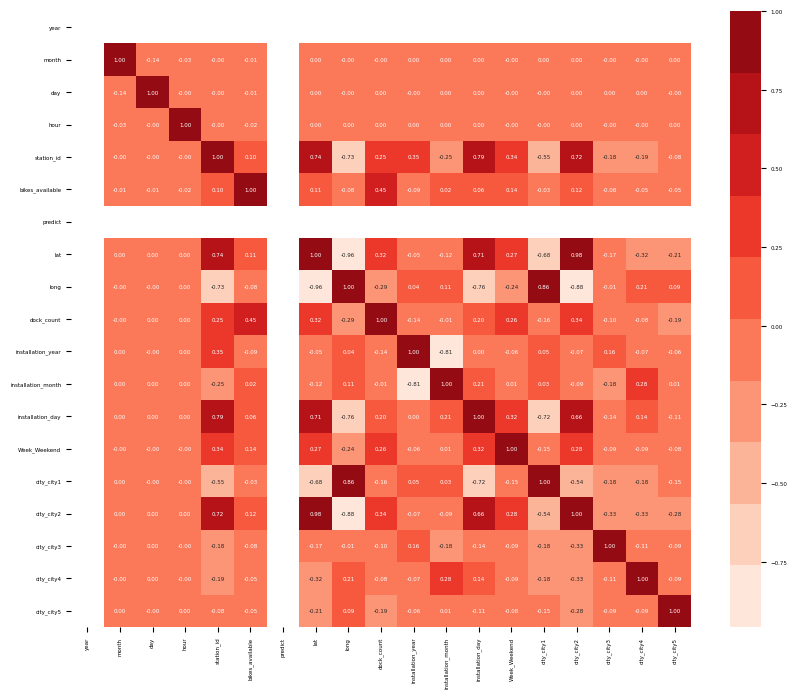

In [17]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
import seaborn as sns
%matplotlib inline
train_total[0].info()
corrs = np.corrcoef(train_total[0], rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=train_total[0].columns.tolist(), yticklabels=train_total[0].columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [18]:
###ここまでできた

y = []
for train in train_total:
    y.append(train['bikes_available'])
    train.drop('bikes_available', axis=1, inplace=True)
    train.drop('predict', axis=1, inplace=True)
    print(train.head())

for test in test_total:
    # bikes_availableは目的変数なのでテストデータには存在しないが、カラムとしては残っているので削除してあげる必要がある。
    test.drop('bikes_available', axis=1, inplace=True)
    test.drop('predict', axis=1, inplace=True)
    print(test.head())


   year  month  day  hour  station_id       lat       long  dock_count   
0  2014      8    1     0           0  37.32973 -121.90178          27  \
1  2014      8    1     1           0  37.32973 -121.90178          27   
2  2014      8    1     2           0  37.32973 -121.90178          27   
3  2014      8    1     3           0  37.32973 -121.90178          27   
4  2014      8    1     4           0  37.32973 -121.90178          27   

   installation_year  installation_month  installation_day  Week_Weekend   
0               2013                   8                 6             0  \
1               2013                   8                 6             0   
2               2013                   8                 6             0   
3               2013                   8                 6             0   
4               2013                   8                 6             0   

   city_city1  city_city2  city_city3  city_city4  city_city5  
0           1           0         

In [21]:
# 上のグリッドサーチで見つけたベストパラメータで全データでの学習、推論を行い結果を算出する。
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     # 'metric': 'rmse',
#     'metric': 'binary_logloss',
#     # 'metric': 'auc', # AUCでもいい
    
#     "seed":31,
#     'random_state': 42,
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     'verbose' : -1,
#     "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
#     "learning_rate": 0.005, #学習率
#     "num_leaves":31,
#     "max_depth":12,
#     "min_data_in_leaf":20,
#     "bagging_fraction":0.8,
#     "bagging_freq":1,
# }
# グリッドサーチは時間かかって終わらないのでそのままにする
# if len(best_params) == 0:
# best_params = params

# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train = []
X_valid = []
y_train = []
y_valid = []
train_total[0].info()
for train_data, y_data in zip(train_total,y):
    train, valid, ytrain, yvalid = train_test_split(train_data, y_data, test_size=0.2, random_state=42)
    X_train.append(train)
    X_valid.append(valid)
    y_train.append(ytrain)
    y_valid.append(yvalid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   lat                 69580 non-null  float64
 6   long                69580 non-null  float64
 7   dock_count          69580 non-null  int64  
 8   installation_year   69580 non-null  int32  
 9   installation_month  69580 non-null  int32  
 10  installation_day    69580 non-null  int32  
 11  Week_Weekend        69580 non-null  int64  
 12  city_city1          69580 non-null  int64  
 13  city_city2          69580 non-null  int64  
 14  city_city3          69580 non-null  int64  
 15  city_city4          69580 non-null  int64  
 16  city

In [22]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

In [23]:
# ## グリッドサーチ
# import lightgbm as lgb

# # https://pythonandai.com/grid-search/
# from sklearn.model_selection import GridSearchCV
# learning_rate = [0.001]
# num_leaves = [31]
# max_depth = [12]
# min_data_in_leaf = [20]
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     # 'metric': 'rmse',
#     'metric': ['binary_logloss',"auc"],
#     # 'metric': 'auc', # AUCでもいい
    
#     # "seed":[31],
#     # 'random_state': [42],
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # 'verbose' : [-1],
#     "num_iterations":[10000], # early stopping で止まるため大きめに設定しておけばよい
    
#     # 以下のパラメータを調整対象とする
#     "learning_rate": learning_rate, #学習率
#     "num_leaves":num_leaves,
#     "max_depth":max_depth,
#     "min_data_in_leaf":min_data_in_leaf,
#     # "bagging_fraction":[0.8],
#     # "bagging_freq":[1],
# }

# lgbm = lgb.LGBMClassifier(random_state=0)
# gcv = GridSearchCV(lgbm, params, cv=3, scoring='precision', return_train_score=True)
# gcv.fit(X_train, y_train)

In [24]:
# # グリッドサーチの結果から、学習データとテストデータのスコアを取得
# train_score = gcv.cv_results_["mean_train_score"]
# test_score = gcv.cv_results_["mean_test_score"]

# # matplotlib.pyplotを省略名pltとしてインポート 
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = 14

# # 学習データのスコアをプロット
# plt.plot(num_leaves, train_score, label="train_score")

# # テストデータのスコアをプロット
# plt.plot(num_leaves, test_score, label="test_score")

# # グラフにタイトルを追加
# plt.title('train_score vs test_score')

# # グラフのx軸に名前を追加
# plt.xlabel('learning_rate')

# # グラフのy軸に名前を追加
# plt.ylabel('precision')

# # 凡例の表示
# plt.legend()

# # グラフの表示
# plt.show()

In [25]:
# # グリッドサーチの結果から、最適なパラメータを表示
# print("Best parameters: ", gcv.best_params_)

# # 最適なパラメータで学習したモデルを取得
# optimal_model = gcv.best_estimator_

# # 最適なモデルを用いて、評価用データの予測を行う
# predicted_values = optimal_model.predict_proba(test_total)[:,1]


In [26]:
# from sklearn import metrics
# # 予測結果を用いてAUCを計算
# auc_score = roc_auc_score(y_test_true, predicted_values)

# predicted_values_int = np.where(predicted_values > 0.5, 1, 0)
# precision_score = metrics.precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# recall_score = metrics.recall_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')
# print(f'recall_score={recall_score}')
# print(f'sum_score={recall_score+precision_score}')


# # 計算したAUCを表示
# print("AUC Score: ", auc_score)
# import seaborn as sns
# from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
#    roc_curve, recall_score, classification_report, f1_score,
#    precision_recall_fscore_support)
# conf_matrix = confusion_matrix(y_test_true, predicted_values_int)
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, xticklabels=["Normal","Fraund"], yticklabels=["Normal","Fraund"], annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()
# # precision_score = precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')

In [27]:
# from sklearn import metrics

# precision, recall, thresholds = metrics.precision_recall_curve(y_test_true, predicted_values)

# auc = metrics.auc(recall, precision)
# print(auc)

# plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
# plt.legend()
# plt.title('PR curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.show()

In [28]:
# y_pred = predicted_values
# y_pred_label_normal_test = y_pred[y_test_true==0]
# y_pred_label_fraud_test = y_pred[y_test_true==1]
# print(len(y_pred_label_normal_test))
# print(len(y_pred_label_fraud_test))

In [29]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Test')


# bins = 50

# ax.hist(y_pred_label_normal_test, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud_test, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('test pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [30]:
# y_pred_train = optimal_model.predict_proba(train_total)[:,1]
# y_pred_label_normal = y_pred_train[y==0]
# y_pred_label_fraud = y_pred_train[y==1]


In [31]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Train')

# bins = 50

# ax.hist(y_pred_label_normal, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('train pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [32]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

# finish

In [33]:
# 上の方法だとうまく重みづけ学習できないので、別ページを参考に実践する
# https://an-engineer-note.com/?p=312#toc3
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
# dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
# dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
dtrain_list = []
dvalid_list = []
for train, valid, ytrain, yvalid in zip(X_train, X_valid, y_train, y_valid):
    dtrain = lgb.Dataset(train, label=ytrain)
    dvalid = lgb.Dataset(valid, label=yvalid)
    # dtrain = lgb.Dataset(train, label=ytrain, weight=compute_sample_weight(class_weight='balanced', y=ytrain).astype('float32'))
    # dvalid = lgb.Dataset(valid, label=yvalid, reference=dtrain)
    dtrain_list.append(dtrain)
    dvalid_list.append(dvalid)
    # https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
    # fobj=fobjというハイパラもある？
    print(compute_sample_weight(class_weight='balanced', y=ytrain).astype('float32'))

[0.32457143 0.4052181  2.112646   ... 0.3730531  0.42725125 0.32457143]
[0.41979805 0.43484226 0.5580986  ... 0.41979805 0.43484226 0.3303804 ]
[0.34523538 3.7205882  0.55675775 ... 3.7205882  0.44121495 0.32839373]
[0.39991075 0.4456603  0.3201143  ... 0.4456603  0.3201143  0.39991075]
[0.31929526 0.40430528 0.38348028 ... 3.5774891  0.4527723  0.40430528]
[0.54395014 0.323146   0.87872916 ... 0.459854   0.87872916 0.401061  ]
[0.7320374  0.3186462  0.32686126 ... 0.46693608 0.8257268  0.4011362 ]
[0.32996514 0.3229239  0.39803264 ... 0.47398353 0.7916076  0.40043026]
[0.47891283 0.33431467 0.47891283 ... 0.47891283 0.7528545  0.3919964 ]
[0.33654726 0.50402796 5.942652   ... 0.48061454 0.7439982  0.39291427]
[0.7448906  0.32812357 0.32812357 ... 0.48291633 0.7448906  0.39213544]
[0.33490792 1.2005593  0.4747512  ... 0.4747512  0.7447957  0.38826367]


In [34]:
learning_rate = 0.001
num_leaves = 31
max_depth = 12
min_data_in_leaf = 20
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'metric': 'binary_logloss',
    # 'metric': 'auc', # AUCでもいい
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [35]:
def gbm_train(dtrain,dvalid):
     #学習
     # 以下を参考にearly stoppingを10で設定
     # https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
     # ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
     # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

     verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
     evaluation_results = {} 
     import time
     starttime = time.time()
     # best_params = gcv.best_params_
     best_params = params

     gbm = lgb.train(best_params,
                    dtrain,
                    #categorical_feature=categorical_features,
                    valid_sets=[dtrain,dvalid],
                    valid_names=['train', 'valid'],     
                    num_boost_round = 10000,
                    # feval=acquire_custom_metircs, 
                    callbacks=[lgb.early_stopping(stopping_rounds=10, 
                                   verbose=True), # early_stopping用コールバック関数
                              lgb.log_evaluation(verbose_eval),
                              lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                    )
     end_time = time.time() - starttime
     print("elapsed time is {}".format(end_time))
     return gbm, evaluation_results


In [36]:
def training_viz(evaluation_results):
    # 学習過程の可視化
    plt.rcParams["font.size"] = 12
    plt.plot(evaluation_results['train']['rmse'], label='train')
    plt.plot(evaluation_results['valid']['rmse'], label='valid')
    plt.ylabel('binary_loglosse')
    plt.xlabel('Boosting round')
    plt.title('Training performance')
    plt.legend()
    plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 55664, number of used features: 16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.20511	valid's rmse: 3.24564
elapsed time is 19.66337251663208
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 71008, number of used features: 16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.42282	valid's rmse: 3.44379
elapsed time is 16.41130256652832
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 85008, number of used features: 16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.44415	valid's rmse: 3.49991
elapsed time is 21.011940956115723
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 100352, number of used features: 16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.50525	valid's rmse: 3.52873
elapsed time is 22.231566905975342
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 115696, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2179]	train's rmse: 4.21964	valid's rmse: 3.85061
elapsed time is 7.38143253326416
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 127008, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2387]	train's rmse: 4.21003	valid's rmse: 3.89071
elapsed time is 7.671196460723877
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 142352, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.64663	valid's rmse: 3.6382
elapsed time is 25.78197979927063
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 156352, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.66409	valid's rmse: 3.62731
elapsed time is 19.65974998474121
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 171696, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.67645	valid's rmse: 3.67872
elapsed time is 21.69722270965576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 185696, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.69908	valid's rmse: 3.69386
elapsed time is 23.95648694038391
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 201040, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.74849	valid's rmse: 3.70025
elapsed time is 25.182801246643066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 216384, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 13.500000
Training until validation scores don't improve for 10 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[10000]	train's rmse: 3.7771	valid's rmse: 3.72185
elapsed time is 27.485049962997437


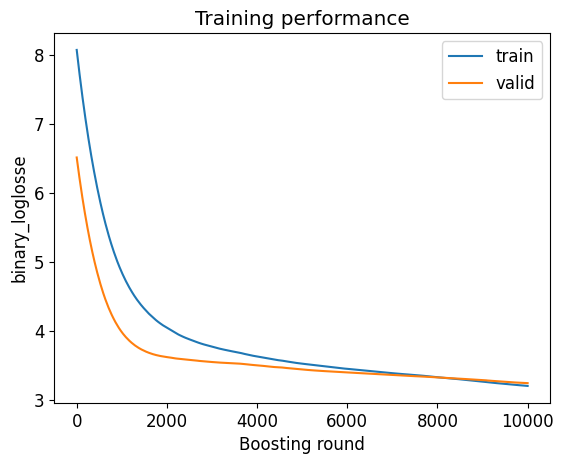

In [37]:
# 12個分のデータをfor文で回す
gbm_list = []
evaluation_results_list = []
for dtrain, dvalid in zip(dtrain_list,dvalid_list):
    gbm, evaluation_results = gbm_train(dtrain,dvalid)
    gbm_list.append(gbm)
    evaluation_results_list.append(evaluation_results)
training_viz(evaluation_results_list[0])


In [38]:
y_pred_list = []
for test in test_total:
    y_pred = gbm.predict(test)
    y_pred_list.append(y_pred)

In [39]:
def pred_hist_viz(y_pred_train, yvalid):
    f, (ax) = plt.subplots()
    f.suptitle('Prediction hist Train')

    bins = 50

    ax.hist(y_pred_train, bins = bins)
    ax.set_title('predict')

    ax.hist(yvalid, bins = bins)
    ax.set_title('correct')

    plt.xlabel('train pred')
    plt.ylabel('Frequencey')
    plt.xlim((0, 30))
    plt.yscale('log')
    plt.text(0.05, 0.92, 'predict  = Blue',transform = ax.transAxes, fontsize = 14)
    plt.text(0.05, 0.86, 'correct = Orange',transform = ax.transAxes, fontsize = 14)
    plt.show();

13916 13916
[7.39409796 8.18773516 6.84056703 ... 7.31281991 6.45590325 7.09567381]
17752 17752
[ 9.34217168 17.37075683 12.18815388 ...  3.55876182  7.0879287
  6.99986025]
21252 21252
[18.80567994 11.78784178  7.72427026 ... 10.9666182   7.06454984
 13.22661105]
25088 25088
[ 8.71634125  5.18329919  6.70886022 ... 11.47683214  7.31987363
  6.78277386]
28924 28924
[6.6509475  6.51938008 5.76018548 ... 9.0886687  7.07277032 8.53759965]
31752 31752
[13.78684762  5.6765267   4.85176781 ...  7.53475741  8.39989481
 20.02726881]
35588 35588
[10.8720451   9.01789206 13.95912789 ...  5.78097541  8.46543807
  7.66961549]
39088 39088
[ 7.97143416  5.12346295  9.94143311 ... 11.94030802  7.77314813
  7.85169622]
42924 42924
[ 6.18568123 10.67988922  6.87765138 ...  4.78932     7.79985666
  3.11550204]
46424 46424
[3.11751608 6.71508186 3.6474688  ... 6.52412876 7.99553123 8.76369779]
50260 50260
[12.41037304 10.66027982  9.38218188 ...  5.45816021 14.59467642
  7.49326922]
54096 54096
[ 4.49382

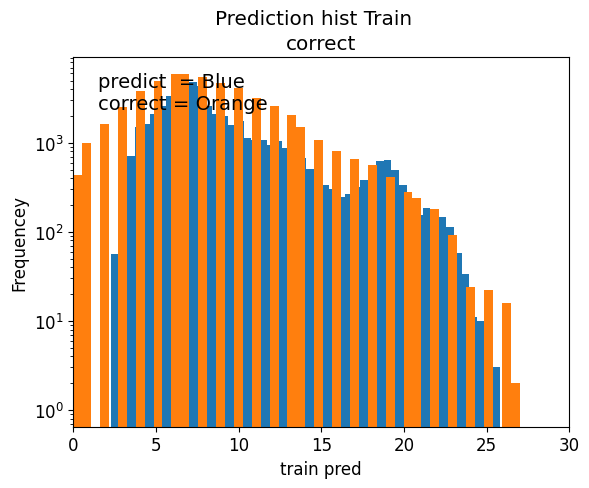

In [40]:
y_pred_train_list = []

for xvalid, yvalid in zip(X_valid,y_valid):
    # print(len(xvalid),len(yvalid))
    y_pred_train = gbm.predict(xvalid)
    # print(y_pred_train)
    y_pred_train_list.append(y_pred_train)
pred_hist_viz(y_pred_train, yvalid)

In [41]:
X_valid[0].describe()

,year,month,day,hour,station_id,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
count,13916.0,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000
mean,2014.0,8.249784,15.251006,11.379132,34.754024,37.592785,-122.220674,17.637971,2013.041463,7.939135,17.096148,0.074734,0.224490,0.506755,0.096005,0.101394,0.071357
std,0.0,0.432904,8.351642,7.009165,20.125351,0.202009,0.207462,3.954285,0.199366,1.454532,6.992925,0.262971,0.417261,0.499972,0.294608,0.301861,0.257429
min,2014.0,8.000000,1.000000,0.000000,0.000000,37.329730,-122.418950,11.000000,2013.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,8.000000,9.000000,5.000000,18.000000,37.389220,-122.400810,15.000000,2013.000000,8.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,8.000000,15.000000,11.000000,35.000000,37.771060,-122.388010,15.000000,2013.000000,8.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2014.0,8.000000,22.000000,17.000000,52.000000,37.788450,-122.076710,19.000000,2013.000000,8.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2014.0,9.000000,31.000000,23.000000,69.000000,37.804770,-121.877350,27.000000,2014.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

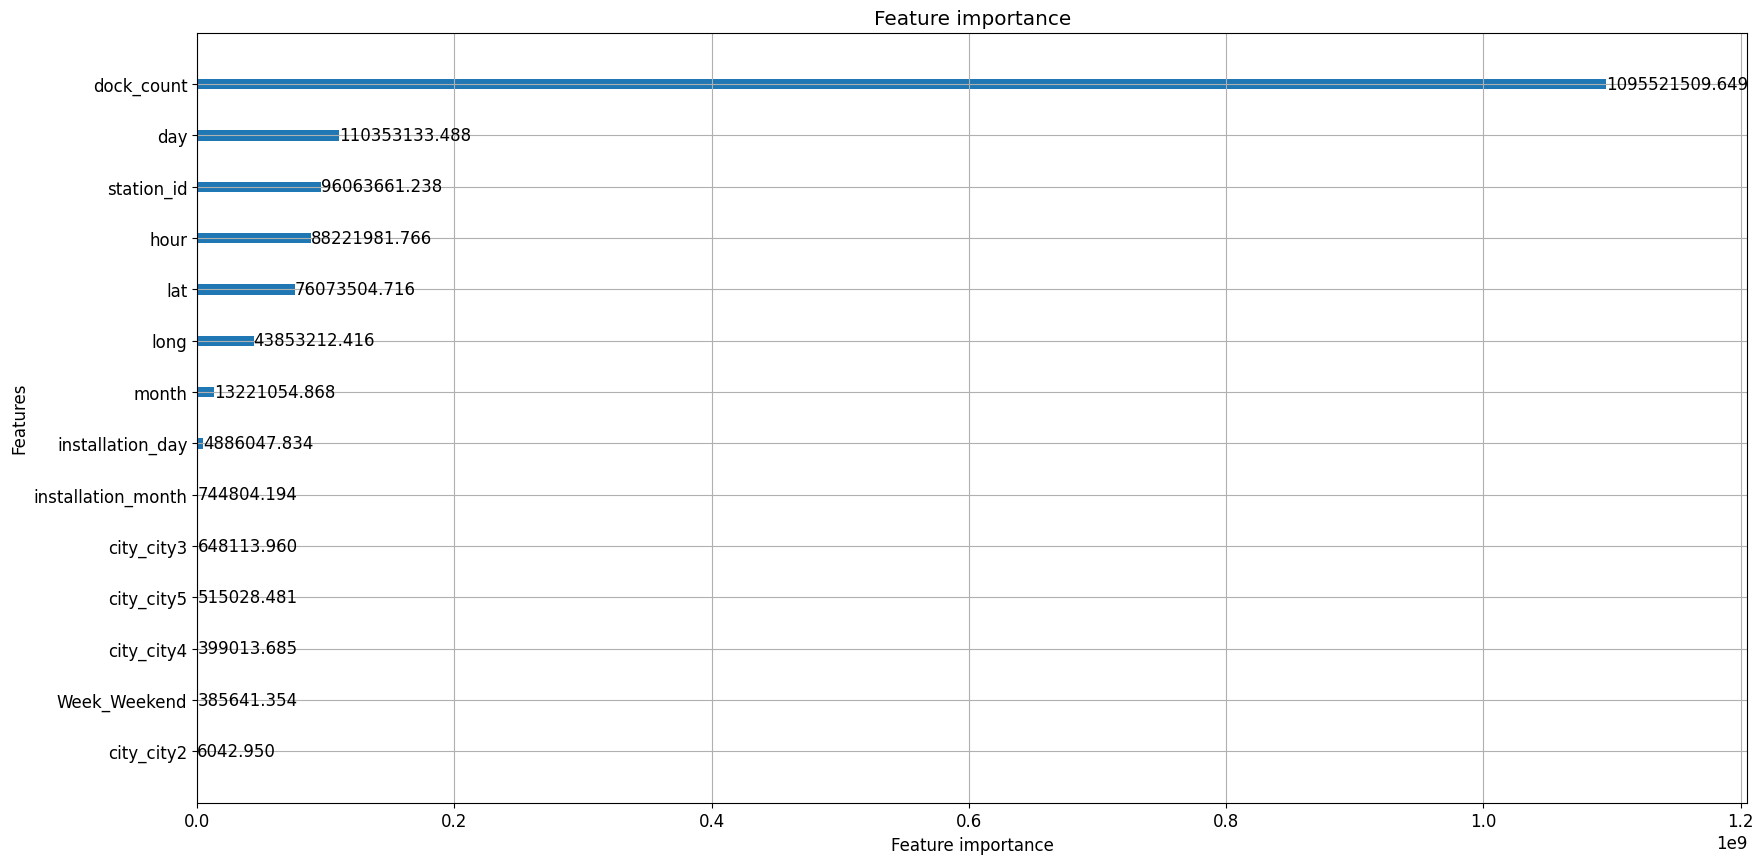

In [42]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
# for gbm in gbm_list:
    # lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')
lgb.plot_importance(gbm_list[0], figsize=(20,10),importance_type='gain')


In [43]:
from sklearn.metrics import mean_squared_error
rmse_list = []
print("check")
print(len(y_valid))
for y_pred, y_true in zip(y_pred_train_list, y_valid):
    print("check")
    y_pred = np.where(y_pred < 0, 0.0, y_pred)
    print("mean_squared_error {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    rmse_list.append(np.sqrt(mean_squared_error(y_true, y_pred)))

check
12
check
mean_squared_error 3.6841161889329372
check
mean_squared_error 3.7316384616246783
check
mean_squared_error 3.7534434489836874
check
mean_squared_error 3.688009737385731
check
mean_squared_error 3.6936760591419735
check
mean_squared_error 3.6880849162735263
check
mean_squared_error 3.714589251886656
check
mean_squared_error 3.6806159379750443
check
mean_squared_error 3.697341306480912
check
mean_squared_error 3.709241271193186
check
mean_squared_error 3.7110573896118844
check
mean_squared_error 3.7218520901797354


       y_real     y_pred
0         6.0   7.394098
1         5.0   8.187735
2         3.0   6.840567
3        13.0  11.992423
4         8.0  10.367952
...       ...        ...
13911     9.0   7.820966
13912     4.0   4.242438
13913     4.0   7.312820
13914    13.0   6.455903
13915     7.0   7.095674

[13916 rows x 2 columns]
       y_real     y_pred
0         9.0   9.342172
1        15.0  17.370757
2        12.0  12.188154
3         1.0   5.468284
4         9.0   8.253018
...       ...        ...
17747     6.0   9.302622
17748    17.0  13.145491
17749     9.0   3.558762
17750     7.0   7.087929
17751     6.0   6.999860

[17752 rows x 2 columns]
       y_real     y_pred
0        16.0  18.805680
1        10.0  11.787842
2         8.0   7.724270
3        19.0  18.731840
4         8.0  10.356690
...       ...        ...
21247     6.0   6.479255
21248    15.0  11.577203
21249     7.0  10.966618
21250     7.0   7.064550
21251     1.0  13.226611

[21252 rows x 2 columns]
       y_real     y_pr

<AxesSubplot:ylabel='Density'>

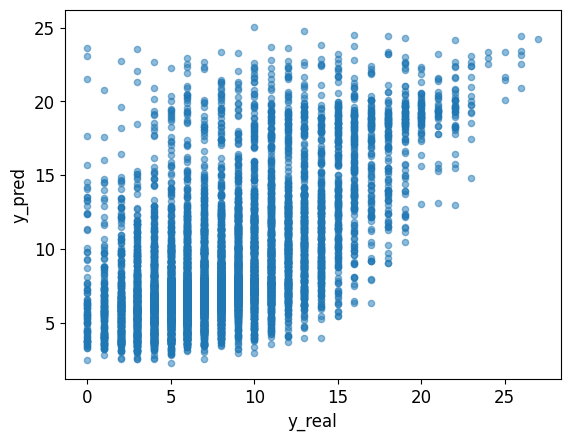

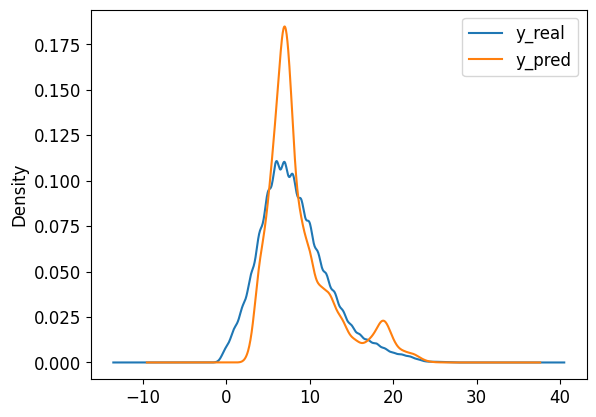

In [79]:
# 予測値グラフ化
def Prediction_accuracy(pred_df,rmse):
    # MSE = mean_squared_error(pred_df['y_test'], pred_df['y_pred']) 
    # RMSE = np.sqrt(mean_squared_error(pred_df['y_test'], pred_df['y_pred']))
    # r2 = r2_score(pred_df['y_test'], pred_df['y_pred'])
    plt.figure(figsize = (5,5))
    ax = plt.subplot(111)
    ax.scatter('y_real', 'y_pred', data = pred_df,alpha=0.9)
    ax.set_xlabel('y_real', fontsize = 14)
    ax.set_ylabel('y_pred', fontsize = 14)
    plt.tick_params(labelsize = 15)
    ax.plot('y_pred','y_pred',data=pred_df,color='red',alpha =0.5)
    plt.text(0.05, 0.92, 'RMSE  = {}'.format(str(round(rmse,3))),transform = ax.transAxes, fontsize = 14)
    # plt.text(0.05, 0.80, 'R²   = {}'.format(str(round(r2,3))),transform = ax.transAxes, fontsize = 14)
    plt.show();
    # print(pred_df.describe())
    # print(pred_df.head())

for y_pred, y_true, rmse in zip(y_pred_train_list, y_valid, rmse_list):
    y_true = y_true.reset_index()
    y_true.drop("index", axis=1, inplace=True)
    # 検証データで予測精度を確認
    pred_df_light = pd.concat([y_true, pd.Series(y_pred)], axis = 1)
    pred_df_light.columns = ['y_real', 'y_pred']
    print(pred_df_light)
    Prediction_accuracy(pred_df_light[:5000],rmse)
pred_df_light.to_csv("check_validation_result.csv")
pred_df_light[:10000].plot.scatter(x='y_real', y='y_pred', alpha=0.5)
pred_df_light.plot.kde()

In [45]:
# # テストデータで推論
# test_lightgbm = gbm.predict(X_submit_test)
# # 提出用に、y_pred<0の場合に0を補完する
# test_lightgbm = np.where(test_lightgbm < 0, 0, test_lightgbm)
# out_lightgbm = pd.DataFrame({"datetime":test_original_data['datetime'], "count":test_lightgbm})
# import datetime
# time = datetime.datetime.now()
# out_lightgbm.to_csv('output_lightbgm' + str(time) + '.csv', index = False)
# print(X_train.columns.tolist())

In [46]:
import os

if(os.path.isfile('submission_before_sort.csv')):
    os.remove('submission_before_sort.csv')
    
if(os.path.isfile('submission.csv')):
    os.remove('submission.csv')

In [47]:
for test_id, y_test in zip(test_id_list,y_pred_list):
    y_test = np.where(y_test < 0.0, 0.0, y_test)
    # make submission file
    # test_id = test_id.to_numpy()
    # print(test_id)
    # submission_pd = pd.DataFrame({test_id, y_test})
    submission_pd = pd.concat([test_id, pd.DataFrame(y_test)], axis=1)
    # submission_pd.info()
    # submission_pd.to_csv("submission.csv", index = False,mode='a')
    submission_pd.to_csv("submission_before_sort.csv", index = False, header = False,mode='a')


In [48]:
submission_check_pd = pd.read_csv('submission_before_sort.csv', header=None, names=['id', 'predict'])

In [49]:
submission_check_pd.describe()

,id,predict
count,1.932000e+05,193200.000000
mean,6.175536e+05,8.845227
std,3.540048e+05,4.111708
min,8.761000e+03,2.089080
25%,3.109385e+05,6.146048
50%,6.175560e+05,7.565094
75%,9.241255e+05,10.285224
max,1.226351e+06,25.724812


In [50]:
submission_check_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193200 entries, 0 to 193199
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193200 non-null  int64  
 1   predict  193200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


In [51]:
submission_check_pd = submission_check_pd.sort_values('id')

In [52]:
submission_check_pd.head()
submission_check_pd.to_csv("submission.csv", index = False, header = False)